## [Langserve Integration](https://langfuse.com/guides/cookbook/integration_langserve)

LangServe helps developers deploy LangChain runnables and chains as a REST API.

This library is integrated with FastAPI and uses pydantic for data validation.

In addition, it provides a client that can be used to call into runnables deployed on a server. A JavaScript client is available in LangChain.js.

### Step 0:Setup

In [1]:
#%pip install fastapi sse_starlette httpx langserve "langfuse<3.0.0" langchain-openai langchain
%pip install fastapi sse_starlette httpx langserve langchain-openai langchain

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
     ----------------- ---------------------- 0.5/1.2 MB 4.2 MB/s eta 0:00:01
     ---------------------------------------- 1.2/1.2 MB 4.5 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
import os

# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-962190cc-b2bd-47c0-b752-8de287a2a5c1"
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-4e9959c3-0935-4142-b789-734beb81d15a"
os.environ["LANGFUSE_HOST"] = "http://localhost:3000"

# Your openai key
# os.environ["OPENAI_API_KEY"] = "f0c1fb9f5c534e55a66d9e539916fdb0.GQKa6HaX6MpT9ioJ"
os.environ["OPENAI_API_KEY"] = "73c80b33ad68446ea3f059efe5c1a65f.T2PZjYiHcT2JYx2a"
os.environ["OPENAI_BASE_URL"] = "https://open.bigmodel.cn/api/paas/v4"

In [7]:
from langfuse import get_client
 
langfuse = get_client()
 
# Verify connection
if langfuse.auth_check():
    print("Langfuse client is authenticated and ready!")
else:
    print("Authentication failed. Please check your credentials and host.")

Langfuse client is authenticated and ready!


### Step 1: Simple LLM Call Example

Initialize the Langfuse client and configure the LLM with Langfuse as callback handler. Add to Fastapi via Langserve’s add_routes().

In [21]:
from langchain_openai import ChatOpenAI
from langchain_core.runnables.config import RunnableConfig
from langfuse import Langfuse
from langfuse.langchain import CallbackHandler
from fastapi import FastAPI
from langserve import add_routes


langfuse_handler = CallbackHandler()

llm = ChatOpenAI(model="GLM-4.5-Flash")

config = RunnableConfig(callbacks=[langfuse_handler])

llm_with_langfuse = llm.with_config(config)

# Setup server
app = FastAPI()

add_routes(app, llm_with_langfuse, path="/test-simple-llm-call")

In [9]:
# Put this cell right before your TestClient call to see the real error body
import traceback, json, os
from fastapi.testclient import TestClient

client = TestClient(app)
try:
    resp = client.post("/test-simple-llm-call/invoke", json={"input": "Tell me a joke?"}, timeout=60)
    print("status", resp.status_code)
    try:
        print("json:", json.dumps(resp.json(), ensure_ascii=False, indent=2))
    except Exception:
        print("text:", resp.text)
except Exception as e:
    print("REQUEST EXCEPTION:", type(e), e)
    traceback.print_exc()
    # 诊断环境
    print("OPEN_AI_URL:", os.environ.get("OPEN_AI_URL"))
    print("OPENAI_API_KEY set?:", bool(os.environ.get("OPENAI_API_KEY")))

status 200
json: {
  "output": {
    "content": "Sure! Here's a classic one for you:  \n\n**Why don't scientists trust atoms?**  \n*Because they make up everything!* 😄  \n\nNeed another? Just say the word!",
    "additional_kwargs": {
      "refusal": null
    },
    "response_metadata": {
      "token_usage": {
        "completion_tokens": 212,
        "prompt_tokens": 10,
        "total_tokens": 222,
        "completion_tokens_details": null,
        "prompt_tokens_details": {
          "audio_tokens": null,
          "cached_tokens": 4
        }
      },
      "model_name": "GLM-4.5-Flash",
      "system_fingerprint": null,
      "id": "20250902094105094a987173104e53",
      "service_tier": null,
      "finish_reason": "stop",
      "logprobs": null
    },
    "type": "ai",
    "name": null,
    "id": "run--77434c0a-ced7-42f1-a1c8-c1b67ae764e4-0",
    "example": false,
    "tool_calls": [],
    "invalid_tool_calls": [],
    "usage_metadata": {
      "input_tokens": 10,
      "output

[trace](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/traces/69d004e321b0b16a67e6892a804e523f?timestamp=2025-09-02T01%3A41%3A03.929Z&display=details&view=preview&observation=4d22e549a5f328fd)

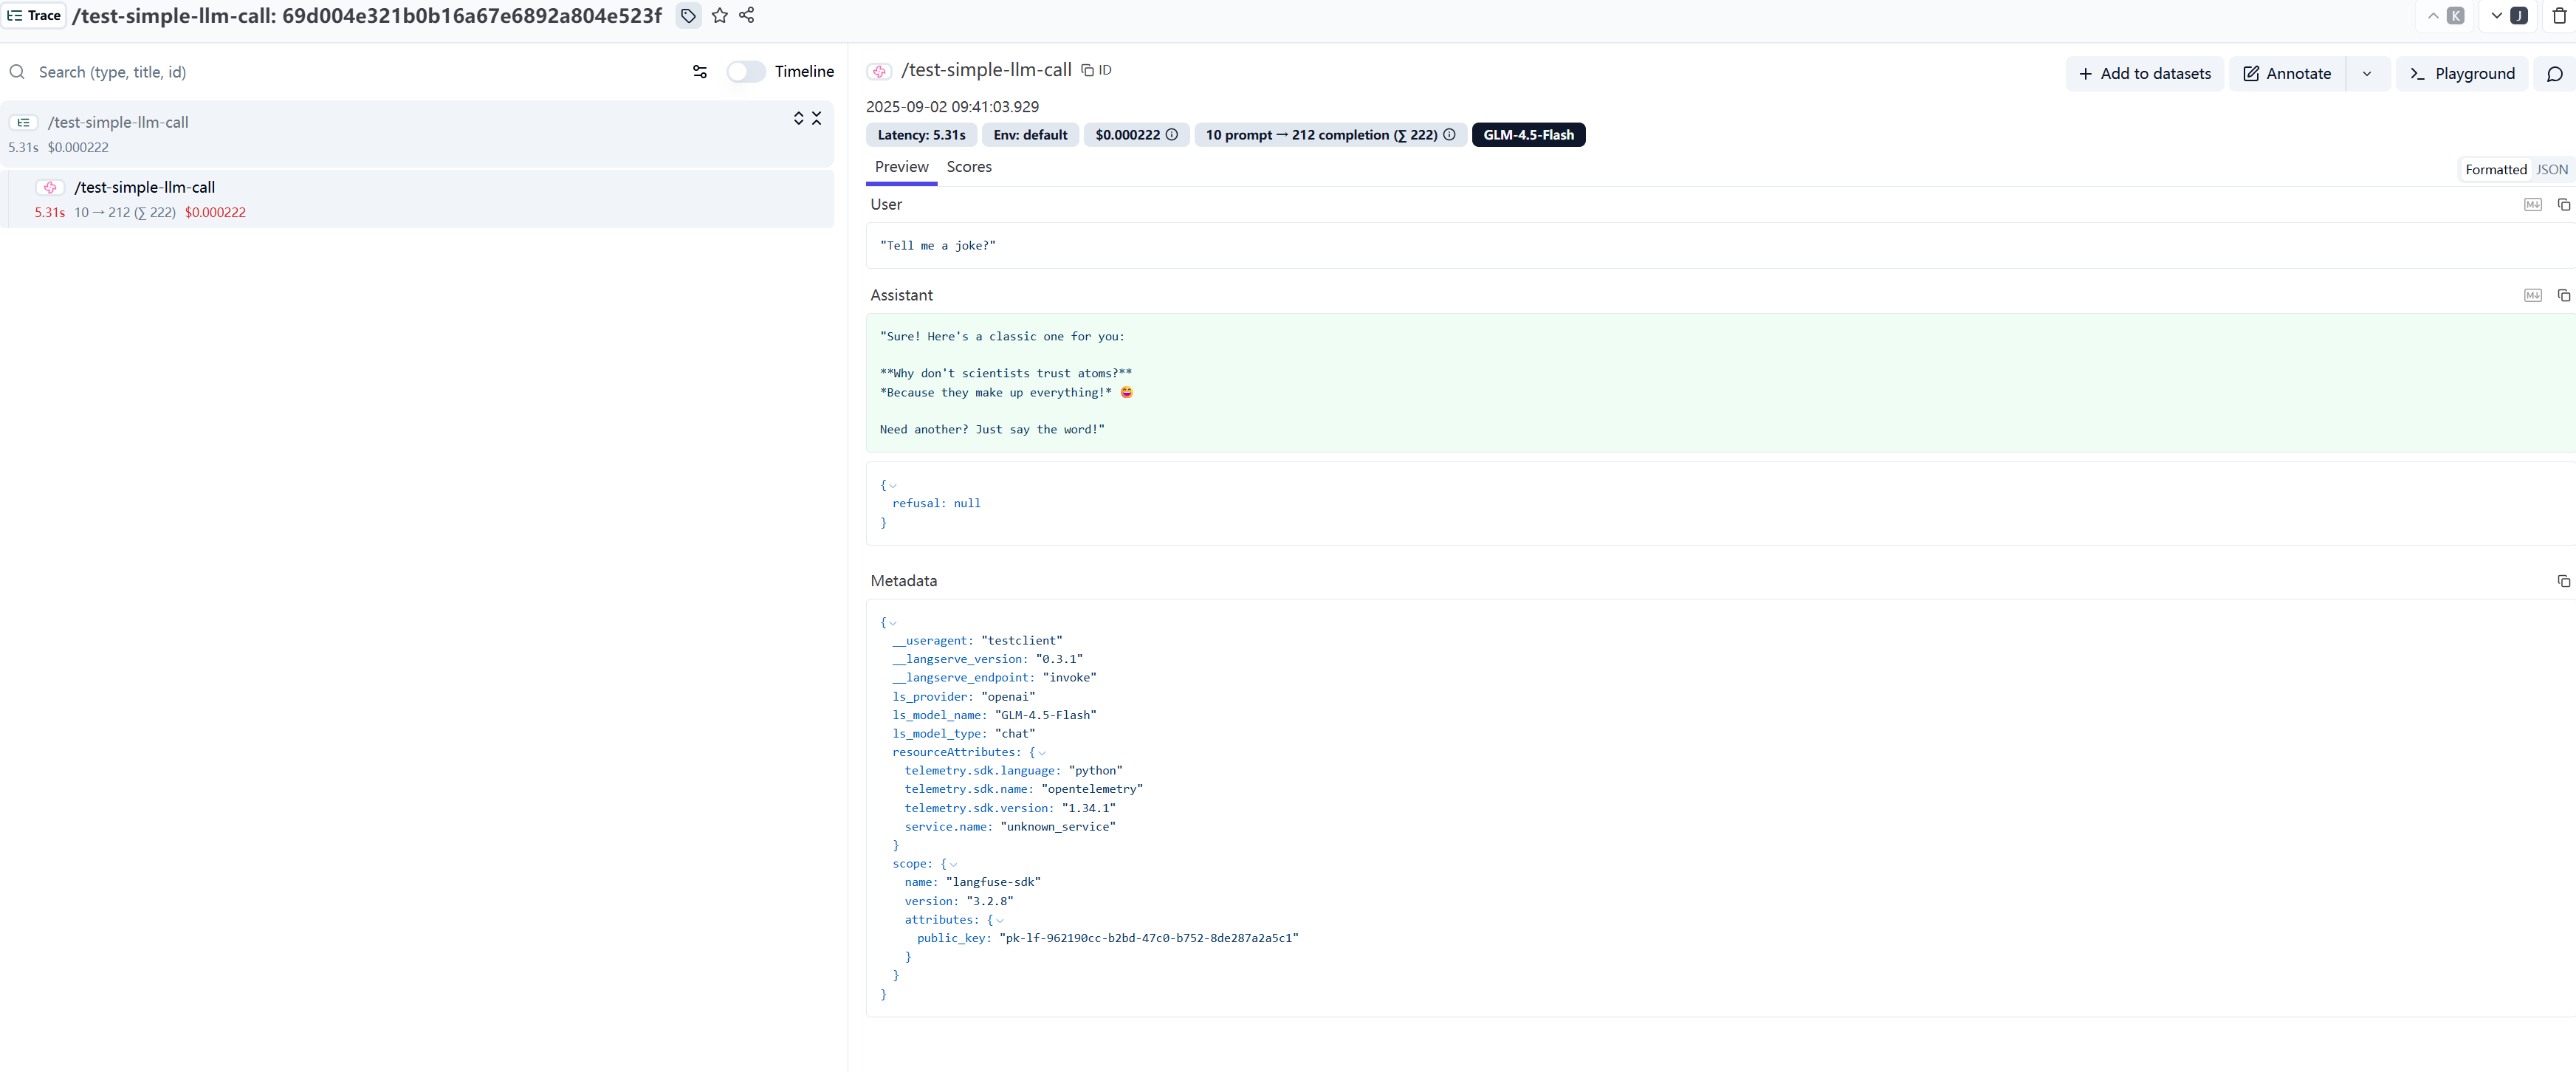

### Step 2: LCEL example

In [22]:
from langchain.prompts import ChatPromptTemplate
from langchain.schema import StrOutputParser
from langserve import add_routes

# Create Chain
prompt = ChatPromptTemplate.from_template("Tell me a joke about {topic}")

chain = prompt | llm | StrOutputParser()

# Add new route
add_routes(app, chain.with_config(config), path="/test-chain")


In [27]:
# Test chain route
import traceback, json, os

from fastapi.testclient import TestClient

client = TestClient(app)

try:
    resp = client.post("/test-chain/invoke", json={"input": {"topic": "the US?"}}, timeout=60)
    print("status", resp.status_code)
    try:
        print("json:", json.dumps(resp.json(), ensure_ascii=False, indent=2))
    except Exception:
        print("text:", resp.text)
except Exception as e:
    print("REQUEST EXCEPTION:", type(e), e)
    traceback.print_exc()
    print("OPEN_AI_URL:", os.environ.get("OPEN_AI_URL"))
    print("OPENAI_API_KEY set?:", bool(os.environ.get("OPENAI_API_KEY")))

status 200
json: {
  "output": "Here's a classic one about American bureaucracy:\n\n**Why did the American bring a ladder to the DMV?**  \n...Because they heard they needed to **climb the ranks** to get a driver's license!  \n\n*(Bonus: Why did the American cross the road?... To prove to the Russians it *could* be done!)* 😄",
  "metadata": {
    "run_id": "a974beec-f806-4602-9d39-3324031cfe45",
    "feedback_tokens": []
  }
}


[trace](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/traces/81a1fc18490a511e3fbfba31795cb9e8?timestamp=2025-09-02T02%3A05%3A20.982Z&display=details&view=preview)

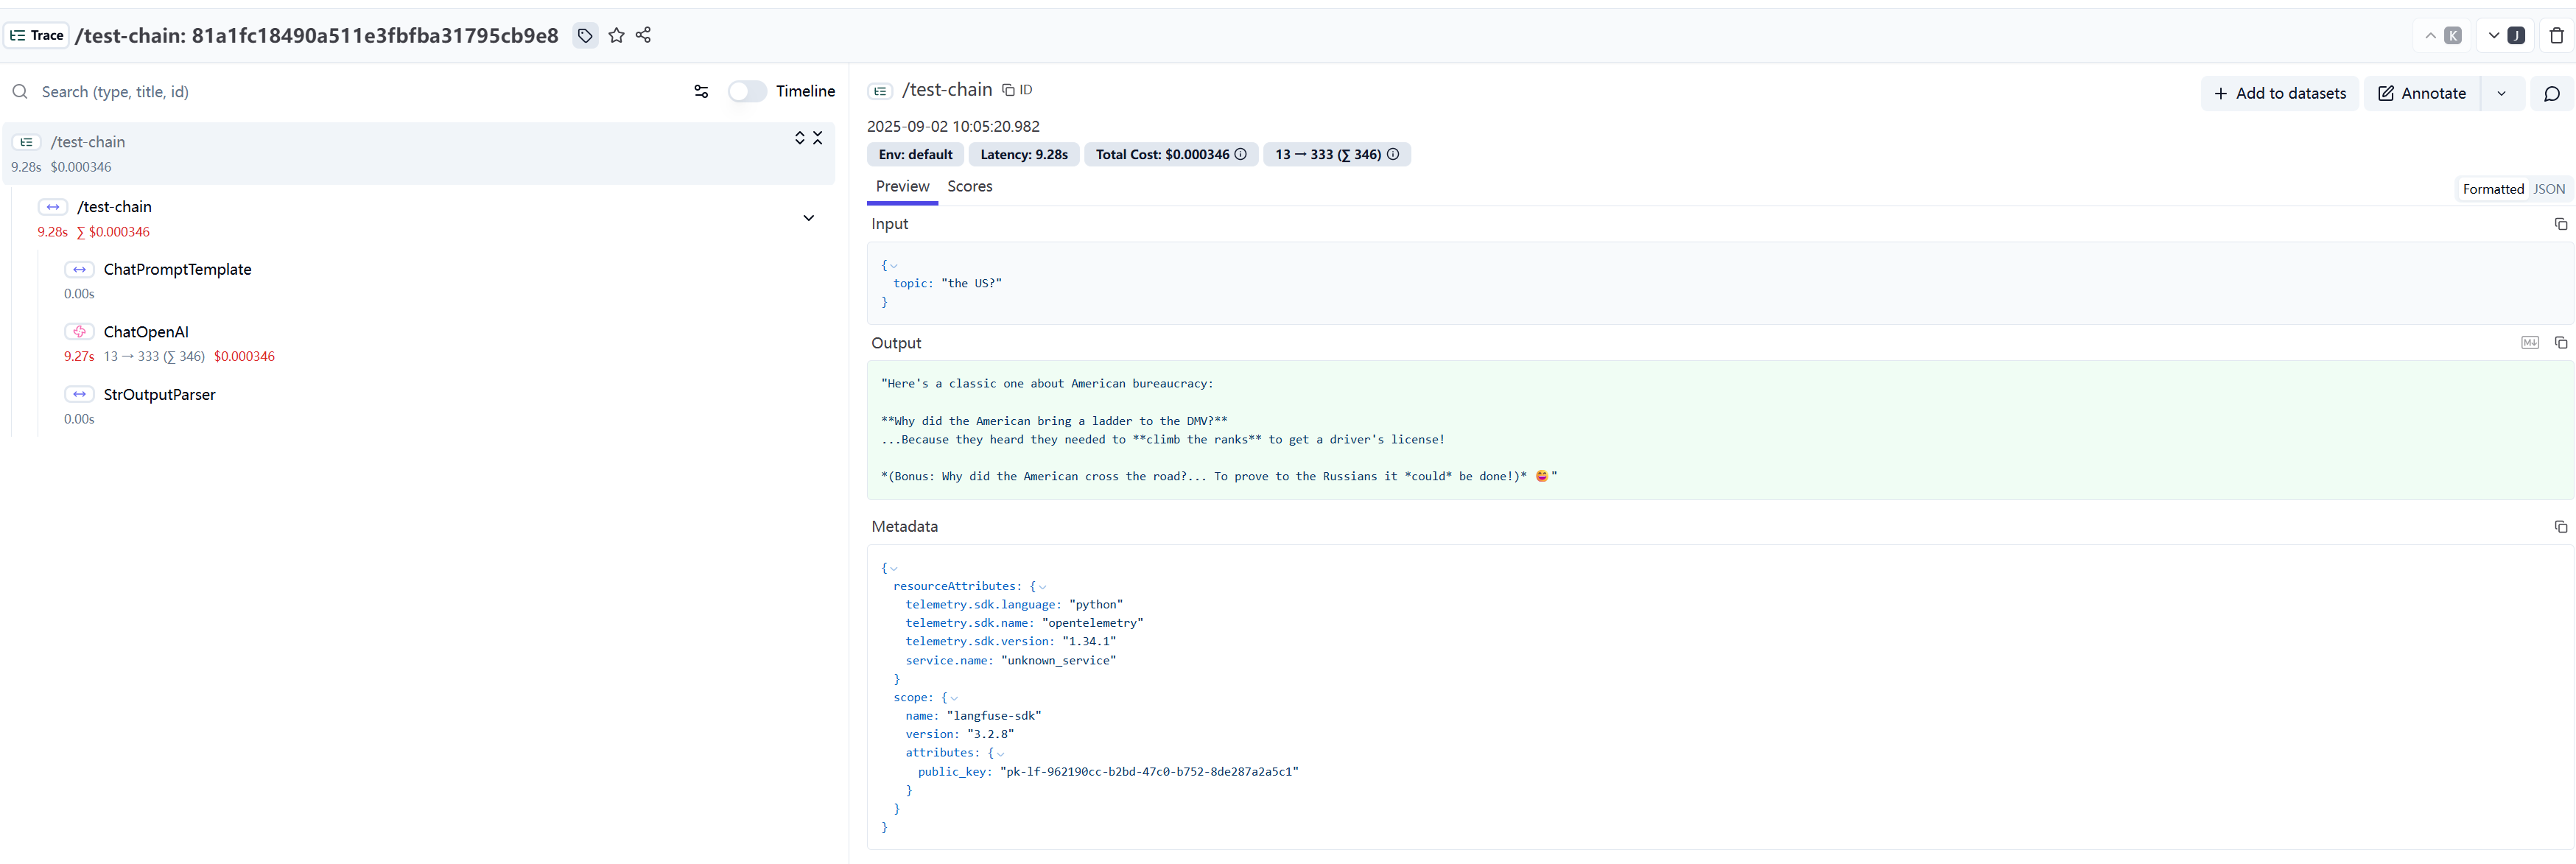

### Step 3: Agent Example

In [31]:
from langchain_core.tools import tool
from langchain_core.utils.function_calling import convert_to_openai_tool
from langchain.agents.format_scratchpad.openai_tools import (
    format_to_openai_tool_messages,
)
from langchain.agents import AgentExecutor
from langchain.agents.output_parsers.openai_tools import OpenAIToolsAgentOutputParser
from pydantic import BaseModel
from langchain_core.prompts import MessagesPlaceholder


class Input(BaseModel):
    input: str


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a helpful assistant."),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="agent_scratchpad"),
    ]
)


@tool
def word_length(word: str) -> int:
    """Returns a counter word"""
    return len(word)


tools = [word_length]

llm_with_tools = llm.bind(tools=[convert_to_openai_tool(t) for t in tools])

agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_to_openai_tool_messages(
            x["intermediate_steps"]
        ),
    }
    | prompt
    | llm_with_tools
    | OpenAIToolsAgentOutputParser()
)

agent_executor = AgentExecutor(agent=agent, tools=tools)

agent_config = RunnableConfig({"run_name": "agent"}, callbacks=[langfuse_handler])

add_routes(
    app,
    agent_executor.with_types(input_type=Input).with_config(agent_config),
    path="/test-agent",
)

In [32]:
# Test agent
import traceback, json, os

from fastapi.testclient import TestClient

client = TestClient(app)

try:
    resp = client.post("/test-agent/invoke", json={"input": {"input": "How long is Leonardo DiCaprios last name?"}}, timeout=60)
    print("status", resp.status_code)
    try:
        print("json:", json.dumps(resp.json(), ensure_ascii=False, indent=2))
    except Exception:
        print("text:", resp.text)
except Exception as e:
    print("REQUEST EXCEPTION:", type(e), e)
    traceback.print_exc()
    print("OPEN_AI_URL:", os.environ.get("OPEN_AI_URL"))
    print("OPENAI_API_KEY set?:", bool(os.environ.get("OPENAI_API_KEY")))

Calling end() on an ended span.
Calling end() on an ended span.


status 200
json: {
  "output": {},
  "metadata": {
    "run_id": "737f113d-bcd9-4042-bae5-a3a9b1f9ea3d",
    "feedback_tokens": []
  }
}


[trace](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/traces/c1297d70ec707920bf4e0cb06c96bdff?timestamp=2025-09-02T02%3A59%3A51.569Z&display=details&observation=398fd18ac1eda229)

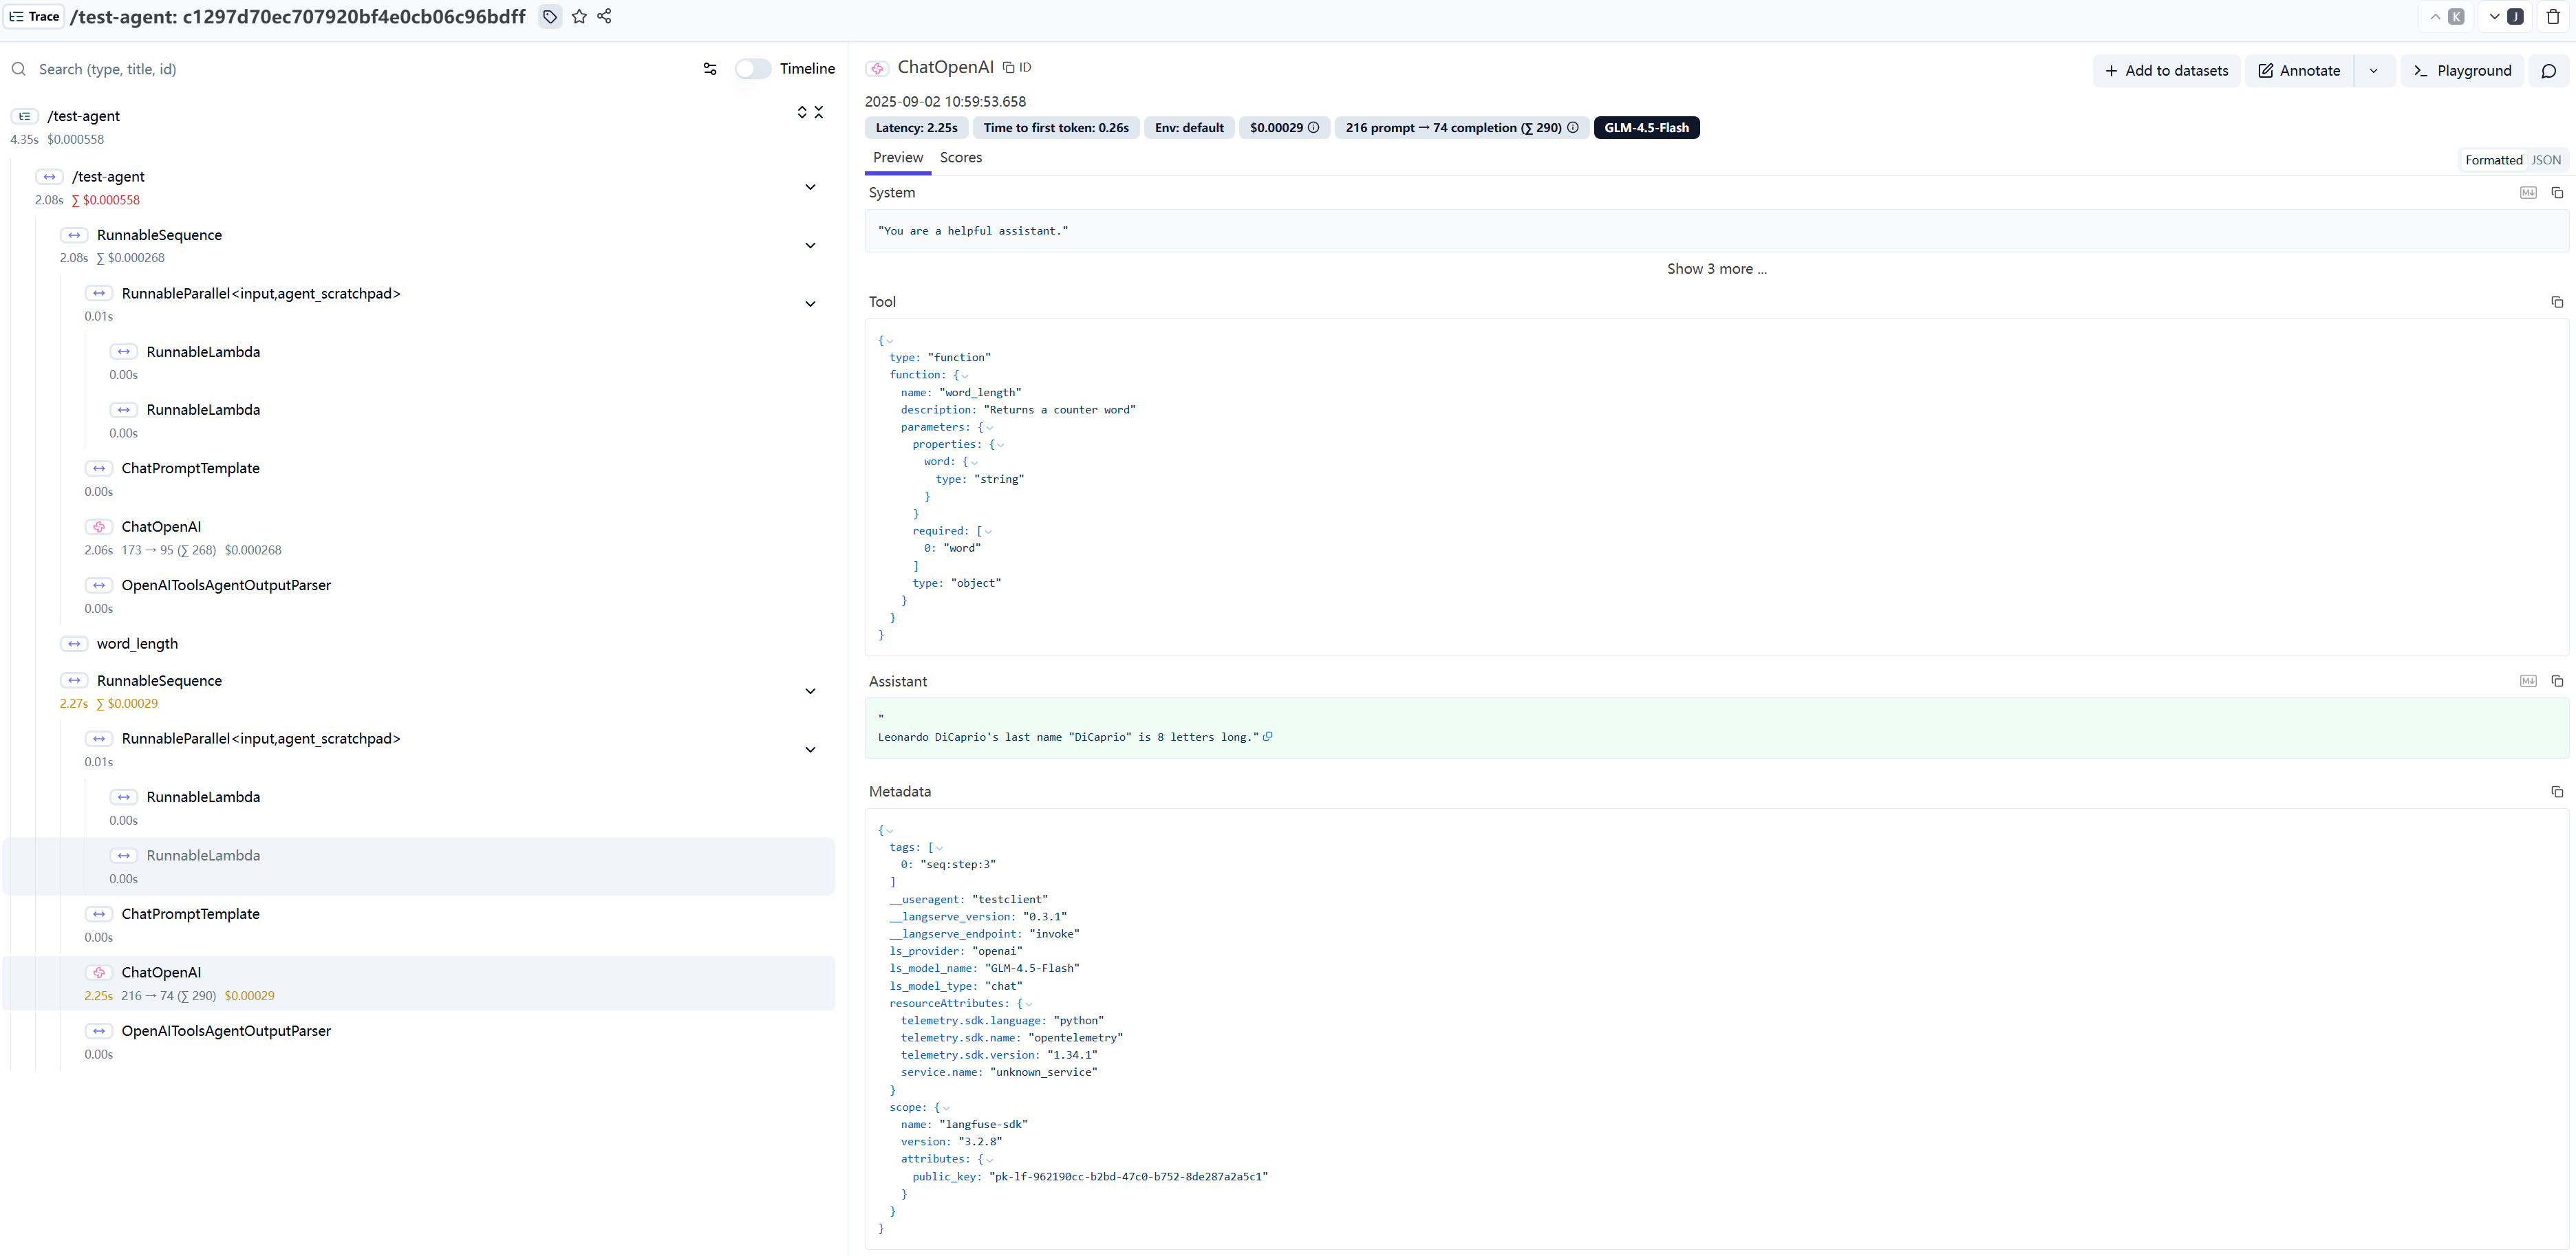